In [62]:
from tsai.all import *
import sklearn.metrics as skm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [63]:
def seed_all(seed=23):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(2025)

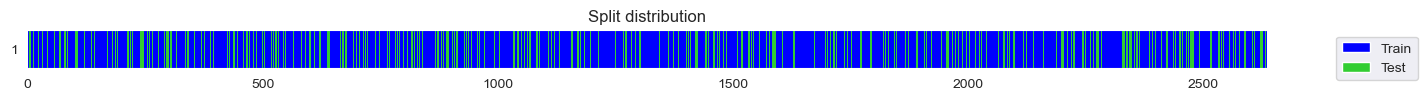

In [64]:
df1 = pd.read_csv(r".\dataset\damage_detection_Vänersborg\type00.csv", index_col=0)
df2 = pd.read_csv(r".\dataset\damage_detection_Vänersborg\type01.csv", index_col=0)
df3 = pd.read_csv(r".\dataset\damage_detection_Vänersborg\type02.csv", index_col=0)

# 读取部分数据，注意这里先用df1、df2、df3各取前176000行后合并
# X, y = df2xy(pd.concat([df1[:176000], df2[:176000], df3[:176000]], ignore_index=True), data_cols=None)
# X = X.reshape(1056, 500, 3)
# X = np.transpose(X, (0, 2, 1))
# # 指定标签（类别0：df1，类别1：df2，类别2：df3）
# label = [0] * 352 + [1] * 352 + [2] * 352
# y = pd.DataFrame(label)
# ——— 显式滑窗划分 ———
def sliding_windows(data: np.ndarray, window_size:int, step:int):
    windows = []
    for start in range(0, len(data) - window_size + 1, step):
        windows.append(data[start:start+window_size])
    return np.stack(windows)

window_size = 500
step        = 250   # 50% 重叠

all_X, all_y = [], []
for df, label in [(df1,0),(df2,1),(df3,2)]:
    arr = df.values               # (T, 3)
    W   = sliding_windows(arr, window_size, step)
    all_X.append(W)               # (Nw, 500, 3)
    all_y += [label] * W.shape[0]

X = np.concatenate(all_X, axis=0)  # (总窗口数, 500, 3)
y = np.array(all_y)                # (总窗口数,)

# 转为 tsai 需要的形状 (N, c_in, seq_len)
X = np.transpose(X, (0, 2, 1))     # (N, 3, 500)


splits = get_splits(y, n_splits=1, valid_size=0.25, test_size=0, train_only=False,
                    show_plot=True, check_splits=True, stratify=True, random_state=23, shuffle=True)


In [65]:
import torch
torch.cuda.is_available()

True

In [66]:
# --- 位置编码模块 ---
class tAPE(nn.Module):
    "time Absolute Position Encoding"
    def __init__(self, d_model:int, seq_len=1024, dropout:float=0.1, scale_factor=1.0):
        super().__init__()
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin((position * div_term) * (d_model/seq_len))
        pe[:, 1::2] = torch.cos((position * div_term) * (d_model/seq_len))
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):  # x: [batch, seq_len, d_model]
        x = x + self.pe
        return self.dropout(x)

In [67]:
class AbsolutePositionalEncoding(nn.Module):
    "Absolute positional encoding"
    def __init__(self, d_model:int, seq_len=1024, dropout:float=0.1, scale_factor=1.0):
        super().__init__()
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        x = x + self.pe
        return self.dropout(x)

In [68]:
class LearnablePositionalEncoding(nn.Module):
    "Learnable positional encoding"
    def __init__(self, d_model:int, seq_len=1024, dropout:float=0.1):
        super().__init__()
        self.pe = nn.Parameter(torch.empty(seq_len, d_model))
        nn.init.uniform_(self.pe, -0.02, 0.02)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        x = x + self.pe
        return self.dropout(x)

In [69]:
# --- 多头自注意力模块 ---
class Attention(nn.Module):
    def __init__(self, d_model:int, n_heads:int=8, dropout:float=0.01):
        super().__init__()
        self.n_heads = n_heads
        self.scale = d_model ** -0.5
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.query = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(d_model)
    def forward(self, x):  # x: [batch, seq_len, d_model]
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out

In [70]:
class Attention_Rel_Scl(nn.Module):
    def __init__(self, d_model:int, seq_len:int, n_heads:int=8, dropout:float=0.01):
        super().__init__()
        self.seq_len = seq_len
        self.n_heads = n_heads
        self.scale = d_model ** -0.5
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.query = nn.Linear(d_model, d_model, bias=False)
        self.relative_bias_table = nn.Parameter(torch.zeros((2 * self.seq_len - 1), n_heads))
        coords = torch.meshgrid((torch.arange(1), torch.arange(self.seq_len)), indexing="xy")
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[1] += self.seq_len - 1
        relative_coords = relative_coords.permute(1, 2, 0)
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)
        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(d_model)
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k) * self.scale
        attn = F.softmax(attn, dim=-1)
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.n_heads))
        relative_bias = relative_bias.reshape(self.seq_len, self.seq_len, -1).permute(2, 0, 1).unsqueeze(0)
        attn = attn + relative_bias
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out


In [71]:
class Attention_Rel_Vec(nn.Module):
    def __init__(self, d_model:int, seq_len:int, n_heads:int=8, dropout:float=0.01):
        super().__init__()
        self.seq_len = seq_len
        self.n_heads = n_heads
        self.scale = d_model ** -0.5
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.query = nn.Linear(d_model, d_model, bias=False)
        self.Er = nn.Parameter(torch.randn(self.seq_len, int(d_model/n_heads)))
        self.register_buffer("mask", torch.tril(torch.ones(self.seq_len, self.seq_len)).unsqueeze(0).unsqueeze(0))
        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(d_model)
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        QEr = torch.matmul(q, self.Er.transpose(0, 1))
        Srel = self.skew(QEr)
        attn = torch.matmul(q, k)
        attn = (attn + Srel) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out
    def skew(self, QEr):
        padded = F.pad(QEr, (1, 0))
        batch_size, n_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, n_heads, num_cols, num_rows)
        Srel = reshaped[:, :, 1:, :]
        return Srel

In [72]:
# --- 定义网络骨干 ---
class ConvTranBackbone(nn.Module):
    def __init__(self, c_in:int, seq_len:int, d_model=16, n_heads:int=8, dim_ff:int=256,
                 abs_pos_encode:str='tAPE', rel_pos_encode:str='eRPE', dropout:float=0.01):
        super().__init__()
        # 卷积嵌入层：先将输入扩展为 [batch, 1, c_in, seq_len]，再进行卷积操作
        self.embed_layer = nn.Sequential(
            nn.Conv2d(1, d_model*4, kernel_size=[1, 7], padding='same'),
            nn.BatchNorm2d(d_model*4),
            nn.GELU()
        )
        self.embed_layer2 = nn.Sequential(
            nn.Conv2d(d_model*4, d_model, kernel_size=[c_in, 1], padding='valid'),
            nn.BatchNorm2d(d_model),
            nn.GELU()
        )
        # 选择绝对位置编码方式
        assert abs_pos_encode in ['tAPE', 'sin', 'learned', None]
        if abs_pos_encode == 'tAPE':
            self.abs_position = tAPE(d_model, dropout=dropout, seq_len=seq_len)
        elif abs_pos_encode == 'sin':
            self.abs_position = AbsolutePositionalEncoding(d_model, dropout=dropout, seq_len=seq_len)
        elif abs_pos_encode== 'learned':
            self.abs_position = LearnablePositionalEncoding(d_model, dropout=dropout, seq_len=seq_len)
        else:
            self.abs_position = nn.Identity()
        # 选择相对位置编码/注意力实现
        assert rel_pos_encode in ['eRPE', 'vector', None]
        if rel_pos_encode == 'eRPE':
            self.attention_layer = Attention_Rel_Scl(d_model, seq_len, n_heads=n_heads, dropout=dropout)
        elif rel_pos_encode == 'vector':
            self.attention_layer = Attention_Rel_Vec(d_model, seq_len, n_heads=n_heads, dropout=dropout)
        else:
            self.attention_layer = Attention(d_model, n_heads=n_heads, dropout=dropout)
        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-5)
        self.LayerNorm2 = nn.LayerNorm(d_model, eps=1e-5)
        self.FeedForward = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout)
        )
    def forward(self, x):  # x: [batch, c_in, seq_len]
        x = x.unsqueeze(1)  # [batch, 1, c_in, seq_len]
        x_src = self.embed_layer(x)
        x_src = self.embed_layer2(x_src).squeeze(2)  # [batch, d_model, seq_len]
        x_src = x_src.permute(0, 2, 1)  # [batch, seq_len, d_model]
        x_src_pos = self.abs_position(x_src)
        att = x_src + self.attention_layer(x_src_pos)
        att = self.LayerNorm(att)
        out = att + self.FeedForward(att)
        out = self.LayerNorm2(out)
        out = out.permute(0, 2, 1)  # [batch, d_model, seq_len]
        return out

In [73]:
class lin_nd_head(nn.Sequential):
    "Module to create a nd output head with linear layers"

    def __init__(self, n_in, n_out, seq_len=None, d=None, flatten=False, use_bn=False, fc_dropout=0.):

        if seq_len is None:
            seq_len = 1
        if d is None:
            fd = 1
            shape = [n_out]
        elif is_listy(d):
            fd = 1
            shape = []
            for _d in d:
                fd *= _d
                shape.append(_d)
            if n_out > 1: shape.append(n_out)
        else: 
            fd = d
            shape = [d, n_out] if n_out > 1 else [d]
            
        layers = []
        if use_bn:
            layers += [nn.BatchNorm1d(n_in)]
        if fc_dropout:
            layers += [nn.Dropout(fc_dropout)]
        if d is None:
            if not flatten or seq_len == 1:
                layers += [nn.AdaptiveAvgPool1d(1), Squeeze(-1), nn.Linear(n_in, n_out)]
                if n_out == 1:
                    layers += [Squeeze(-1)]
            else:
                layers += [Reshape(), nn.Linear(n_in * seq_len, n_out * fd)]
                if n_out * fd== 1:
                    layers += [Squeeze(-1)]
        else:
            if seq_len == 1:
                layers += [nn.AdaptiveAvgPool1d(1)]
            if not flatten and fd == seq_len:
                layers += [Transpose(1,2), nn.Linear(n_in, n_out)]
            else:
                layers += [Reshape(), nn.Linear(n_in * seq_len, n_out * fd)]
            layers += [Reshape(*shape)]

        super().__init__(*layers)
        
create_lin_nd_head = lin_nd_head
lin_3d_head = lin_nd_head # included for backwards compatiblity
create_lin_3d_head = lin_nd_head # included for backwards compatiblity

In [74]:
class HybridHCAN(nn.Module):
    def __init__(self, c_in: int, c_out: int, seq_len: int = 500, d_model: int = 16, fc_channels: int = 128, custom_head=None, **kwargs):
        """
        c_in: 输入通道数
        c_out: 分类类别数
        seq_len: 序列长度，默认值设为500（可根据实际数据调整）
        d_model: 时间分支特征维度（ConvTranBackbone 输出的通道数）
        fc_channels: 变量依赖分支（FCNPlus backbone）输出的通道数
        custom_head: 接收 TSClassifier 传入的额外参数（此处不使用）
        """
        super().__init__()
        # 时间依赖分支（自定义，参考论文提取时序信息）
        self.time_branch = ConvTranBackbone(c_in, seq_len, d_model=d_model, n_heads=8, dim_ff=256,
                                             abs_pos_encode='tAPE', rel_pos_encode='eRPE', dropout=0.01)
        # 变量间依赖分支（利用 tsai 的 FCNPlus，这里我们仅使用其 backbone 部分）
        self.var_branch = FCNPlus(c_in, fc_channels)
        # 定义全局池化：对每个分支的输出在时间维度上进行自适应平均池化
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        # 最终拼接后全连接分类层（输入维度为 d_model + fc_channels）
        self.fc = nn.Linear(d_model + fc_channels, c_out)
        
    def forward(self, x):
        # 输入 x: [batch, c_in, seq_len]
        # 时间依赖分支
        time_feat = self.time_branch(x)               # 输出 shape: [batch, d_model, seq_len]
        time_feat = self.global_pool(time_feat).squeeze(-1)  # 变为 [batch, d_model]
        # 变量间依赖分支：使用 FCNPlus 的 backbone 部分提取特征
        var_feat = self.var_branch.backbone(x)         # 输出 shape: [batch, fc_channels, seq_len]
        var_feat = self.global_pool(var_feat).squeeze(-1)    # 变为 [batch, fc_channels]
        # 拼接两个分支的特征
        combined = torch.cat([time_feat, var_feat], dim=1)  # shape: [batch, d_model + fc_channels]
        # 经过全连接层输出分类结果
        out = self.fc(combined)
        return out


True


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.890047,1.026312,0.644917,00:01
1,0.677431,0.466940,0.901366,00:01
2,0.507158,0.306214,0.922610,00:01
3,0.384939,0.325469,0.930197,00:01
4,0.317753,0.243812,0.898331,00:01
5,0.282716,1.461995,0.599393,00:01
6,0.262932,1.256416,0.611533,00:01
7,0.241922,0.565790,0.666161,00:01
8,0.218199,0.183834,0.907436,00:01
9,0.199217,0.686105,0.616085,00:01


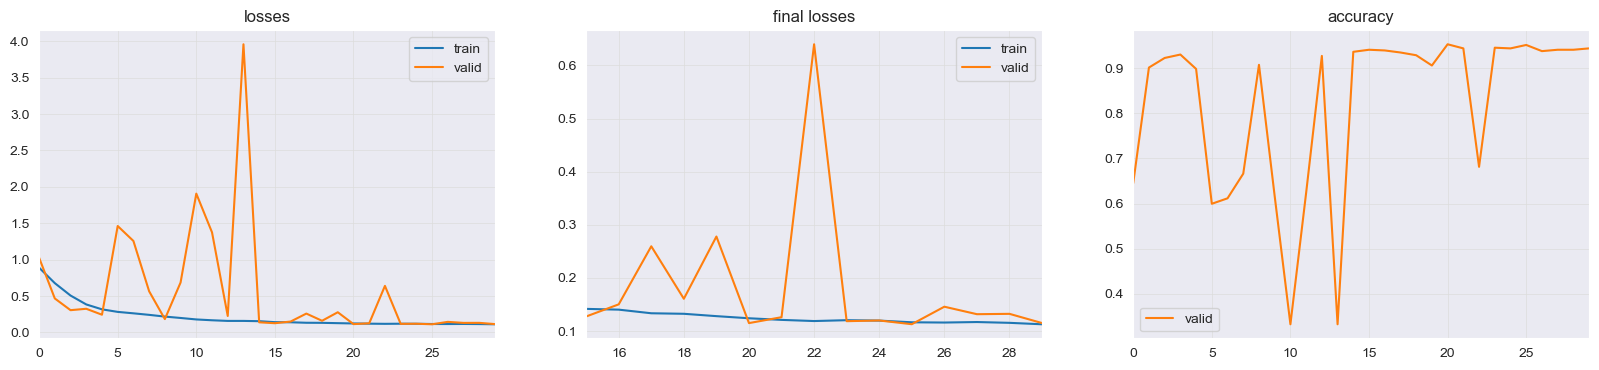

训练时间：42.61937952041626 秒


In [75]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
# 注意：这里将 arch 参数设置为我们自定义的 ConvTran，即使用以多头自注意力为核心的网络
# model = TSClassifier(X, y.values, splits=splits, path='models', arch=HybridHCAN,
#                      tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
model = TSClassifier(X, y, splits=splits, path='models',
                     arch=HybridHCAN,
                     tfms=tfms, batch_tfms=batch_tfms,
                     metrics=accuracy, cbs=ShowGraph())

# 记录训练开始时间
start_time = time.time()
# 打印是否使用gpu
print(torch.cuda.is_available())
model.fit_one_cycle(30, 0.001)
# 记录训练结束时间并输出训练时间
end_time = time.time()
execution_time = end_time - start_time
print(f"训练时间：{execution_time} 秒")
model.export("stage1.pkl")


In [76]:
print(model.model)


HybridHCAN(
  (time_branch): ConvTranBackbone(
    (embed_layer): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 7), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (embed_layer2): Sequential(
      (0): Conv2d(64, 16, kernel_size=(3, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (abs_position): tAPE(
      (dropout): Dropout(p=0.01, inplace=False)
    )
    (attention_layer): Attention_Rel_Scl(
      (key): Linear(in_features=16, out_features=16, bias=False)
      (value): Linear(in_features=16, out_features=16, bias=False)
      (query): Linear(in_features=16, out_features=16, bias=False)
      (dropout): Dropout(p=0.01, inplace=False)
      (to_out): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (LayerNorm): LayerNorm((16

In [77]:
X2, y2 = df2xy(pd.concat([df1[176000:], df2[176000:], df3[176000:]], ignore_index=True), data_cols=None)
X2 = X2.reshape(264, 500, 3)
X2 = np.transpose(X2, (0, 2, 1))
label2 = [0] * 88 + [1] * 88 + [2] * 88
y2 = pd.DataFrame(label2)

from tsai.inference import load_learner
mv_clf = load_learner(r'.\models\stage1.pkl')

start_time1 = time.time()
probas, target, preds = model.get_X_preds(X2[:264], y2.values[:264])
end_time1 = time.time()
execution_time1 = end_time1 - start_time1
print(f"推理时间：{execution_time1} 秒")


推理时间：0.0773313045501709 秒


In [78]:
print(f'accuracy: {skm.accuracy_score(target.to("cpu").numpy().astype(int), preds.astype(int)):10.6f}')
print(f'precision: {skm.precision_score(target.to("cpu").numpy().astype(int), preds.astype(int), average="weighted"):10.6f}')
print(f'recall: {skm.recall_score(target.to("cpu").numpy().astype(int), preds.astype(int), average="weighted"):10.6f}')
print(f'f1: {skm.f1_score(target.to("cpu").numpy().astype(int), preds.astype(int), average="weighted"):10.6f}')


accuracy:   0.992424
precision:   0.992593
recall:   0.992424
f1:   0.992423


In [79]:
with open(r'.\models\stage1.pkl', 'wb') as f:
    pickle.dump(model, f)
file_size = os.path.getsize(r'.\models\stage1.pkl')
print(f"模型文件大小：{file_size / (1024 * 1024)} MB")
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params_count = count_parameters(model)
print(f"模型参数数量：{params_count // 1000}K")


模型文件大小：55.65238952636719 MB
模型参数数量：303K


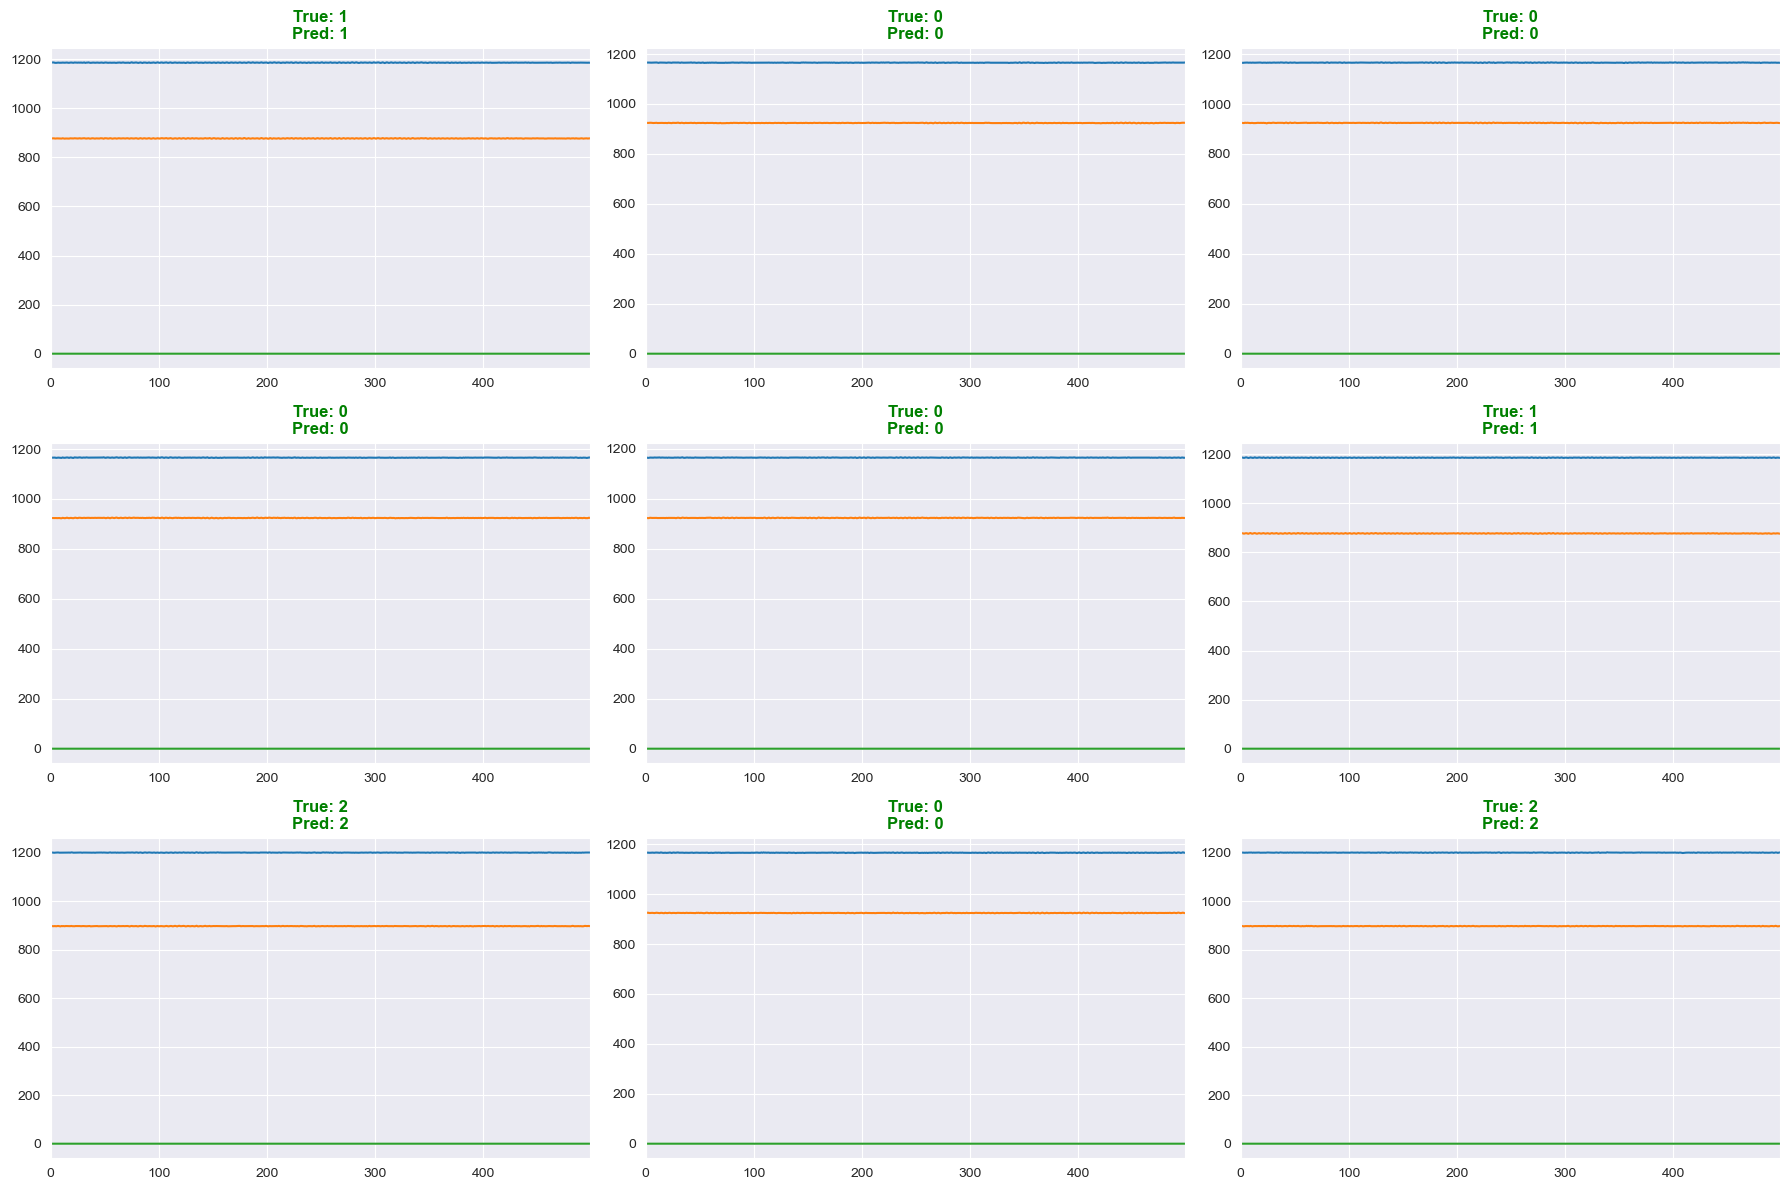

In [80]:
# 展示实际损伤分类和预测分类结果
model.show_results()

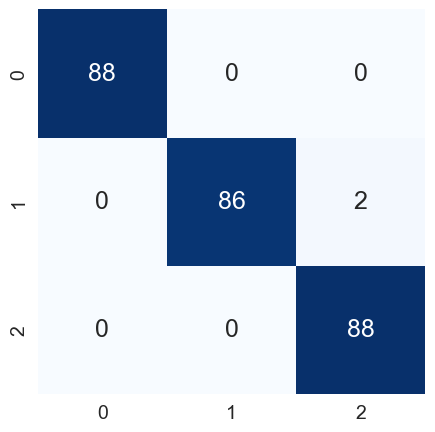

In [81]:
# interp = ClassificationInterpretation.from_learner(model)
# interp.plot_confusion_matrix()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(target.to("cpu").numpy().astype(int), preds.astype(int))

# 选择颜色方案
cmap = 'Blues'  # 或者 'Greys', 'binary'

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,cbar=False,
            annot_kws={"size": 18})  # 设置注释文本的字体大小

# plt.title('Confusion Matrix', fontsize=20)  # 设置标题字体大小
# plt.ylabel('True Label', fontsize=16)  # 设置y轴标签字体大小
# plt.xlabel('Predicted Label', fontsize=16)  # 设置x轴标签字体大小

# 增大刻度标签字体大小
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

X.shape: (1978, 3, 500)
y.shape: (1978,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.935794


  0 feature: var_0                accuracy: 0.333670


  1 feature: var_1                accuracy: 0.324570


  2 feature: var_2                accuracy: 0.930738



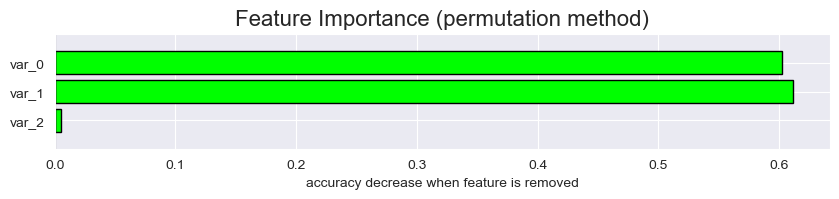

,Feature,accuracy,accuracy_change
0,var_1,0.324570,0.611223
1,var_0,0.333670,0.602123
2,var_2,0.930738,0.005056
3,BASELINE,0.935794,-0.000000


In [82]:
model.feature_importance()

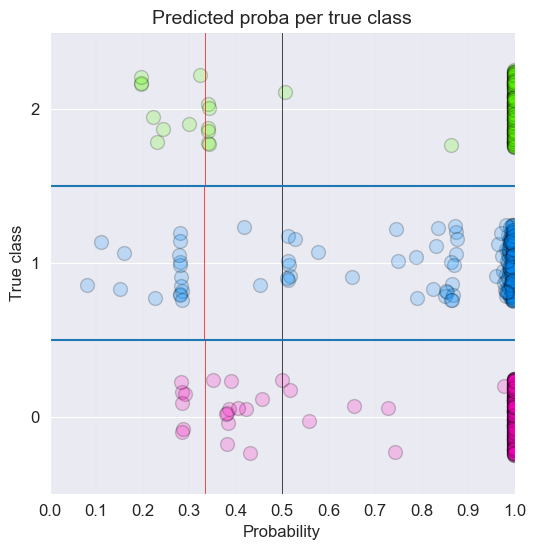

In [83]:
model.show_probas()